# Objective

Investigate precision and recall for all spots in all images in the persistence experiment, using bootstrapping/resampling to get a sense for how much redundancy there is in the persistence dataset annotations.

#### Kevin's notes on bootstapping:

For each image, take a random sample of n workers where n = [1, 2, 3, ..., 25] and calculate the performance. Do this a bunch of times for each image to calculate an average performance for that number of workers for each image. We can then plot a separate Recall vs. n_spots and Precision vs. n_spots rate curve for each number of workers. 

# Takeaway

The evolution of precision and recall with the number of replicates – i.e. the point at which extra workers become redundant for getting accurate spots – varies significantly with the number of spots in the image.

For example, somewhere around 12-15 replicates seems to be sufficient for an accuracy in the ballpark of 90% when the number of spots is around 125 and fewer, while the accuracy doesn't move far from the ballpark of 80% with 18 or more replicates when the number of spots is around 175 and greater.

# Notes

### As expected

All precision and recall plots show overall decrease from left to right (as the number of spots increases), although not all line segments of the curves are negative. For both precision and recall but especially precision, the overall downward trend as num_spots increases becomes less severe as the number of replicates increases. Each line segment often maintains the same slope sign from plot to plot, including both the precision and recall plots. The shape of the precision and recall curves evolve gradually as the number of replicates increases.

### Runtime

This notebook took about 2.5 hours to run, so I saved FPR and TPR data from every iteration of every n and every image as csv files so that we can produce and tweak figures after this kernel is dead.

### Missing markers on some of the scatterplots
Some of the images are annotated by fewer than 25 unique workers. Therefore, some of the num_replicate plots (num_replicates = [24, 25]) lack markers when the number of replicates associated with the plot is greater than the number of workers who actually annotated the image associated with the plot.

In [1]:
import os, sys, math, random
sys.path.insert(0, '../../FISH-annotation/Annotation')
from SpotAnnotationAnalysis import SpotAnnotationAnalysis
from QuantiusAnnotation import QuantiusAnnotation
from sklearn.neighbors import KDTree
import util
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
num_spots_list = np.arange(50, 250, 25)
cwd = os.getcwd()
num_replicates_list = range(2, 26)
num_iter = 10

In [3]:
recall_list, precision_list, TPR_list_list, FPR_list_list = [], [], [], []
print('Progress:')
for n in num_replicates_list:
    print('\n------- num_replicates = ' + str(n) + ' -------')
    
    recall, precision = [], []
    for num_spots in num_spots_list:
        
        json_filepath = cwd + '/annotations/' + 'snr10_' + str(num_spots) + '.json'
        img_filename = 'snr_10_numspots_' + str(num_spots) + '_spot_img.png'
        print('       num_spots = ' + str(num_spots))
        img_filepath = cwd + '/spot_images/' + img_filename
        csv_filepath = cwd + '/spot_data/' + 'snr_10_numspots_' + str(num_spots) + '_coord_snr_list.csv'
        qa = QuantiusAnnotation(json_filepath, img_filename)
        sa = SpotAnnotationAnalysis(qa)
        anno_all = qa.df()

        worker_list = util.get_workers(anno_all)
        if n >= len(worker_list):
            precision.append(None)
            recall.append(None)
            print('              Desired num replicates is greater than num workers who annotated this image')
            continue
        
        TPR_list, FPR_list = [], []
        for i in range(num_iter):
                        
            selected_workers = random.sample(list(worker_list), n)
            anno = anno_all[anno_all.worker_id.isin(selected_workers)]

            clustering_params = ['AffinityPropagation', -350]
            clusters = sa.get_clusters(anno, clustering_params)

            img_height = anno['height'].values[0]

            """ Screen by Cluster Size """
            cluster_size_threshold = util.get_cluster_size_threshold(clusters)
            small_clusters, large_clusters = util.sort_clusters_by_size(clusters, cluster_size_threshold)

            """ Detect Clumps """
            clumpiness_threshold = util.get_clumpiness_threshold(large_clusters)
            clumpy_clusters, nonclumpy_clusters = util.sort_clusters_by_clumpiness(large_clusters, clumpiness_threshold)

            """ Declump """
            declumping_params = ['KMeans', 2]
            result_clusters = nonclumpy_clusters
            for i in range(len(clumpy_clusters.index)):
                subclusters = util.declump(clumpy_clusters, i, declumping_params)
                result_clusters = pd.concat([subclusters, result_clusters], ignore_index=True)

            result_points = result_clusters.loc[:, ['centroid_x', 'centroid_y']].as_matrix()
            result_kdt = KDTree(result_points, leaf_size=2, metric='euclidean')

            ref_df = pd.read_csv(csv_filepath)
            ref_points = ref_df.loc[:, ['col', 'row']].as_matrix().tolist()
            ref_kdt = KDTree(ref_points, leaf_size=2, metric='euclidean')

            """ TPR """
            detected_spots = 0
            for point in ref_points:
                dist, ind = result_kdt.query([[point[0], img_height-point[1]]], k=1)
                if dist[0][0] <= 4:
                    detected_spots += 1
            tpr = float(detected_spots) / num_spots
            TPR_list.append(tpr)

            """ FPR """
            correct_centroids = 0
            for point in result_points:
                dist, ind = ref_kdt.query([[point[0], img_height-point[1]]], k=1)
                if dist[0][0] <= 4:
                    correct_centroids += 1

            fpr = 1 - float(correct_centroids) / num_spots
            FPR_list.append(fpr)
            
        avg_TPR = np.mean(TPR_list)
        avg_FPR = np.mean(FPR_list)
        TPR_list_list.append(TPR_list)
        FPR_list_list.append(FPR_list)
        recall.append(avg_TPR)
        precision.append(1 - avg_FPR)

    recall_list.append(recall)
    precision_list.append(precision)

Progress:

------- num_replicates = 2 -------
       num_spots = 50
       num_spots = 75
       num_spots = 100
       num_spots = 125
       num_spots = 150
       num_spots = 175
       num_spots = 200
       num_spots = 225

------- num_replicates = 3 -------
       num_spots = 50
       num_spots = 75
       num_spots = 100
       num_spots = 125
       num_spots = 150
       num_spots = 175
       num_spots = 200
       num_spots = 225

------- num_replicates = 4 -------
       num_spots = 50
       num_spots = 75
       num_spots = 100
       num_spots = 125
       num_spots = 150
       num_spots = 175
       num_spots = 200
       num_spots = 225

------- num_replicates = 5 -------
       num_spots = 50
       num_spots = 75
       num_spots = 100
       num_spots = 125
       num_spots = 150
       num_spots = 175
       num_spots = 200
       num_spots = 225

------- num_replicates = 6 -------
       num_spots = 50
       num_spots = 75
       num_spots = 100
       num_spot


------------------------ num_replicates = 2 ------------------------


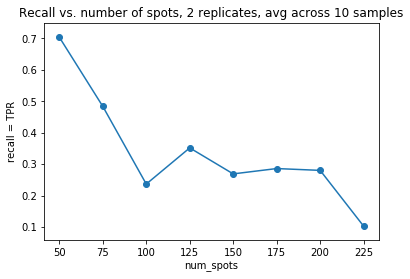

recall = [0.7, 0.48, 0.24, 0.35, 0.27, 0.29, 0.28, 0.1]


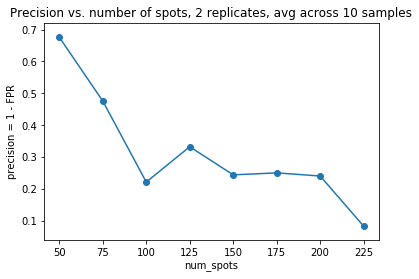

precision = [0.68, 0.48, 0.22, 0.33, 0.24, 0.25, 0.24, 0.08]

------------------------ num_replicates = 3 ------------------------


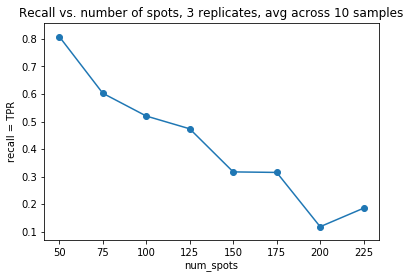

recall = [0.81, 0.6, 0.52, 0.47, 0.32, 0.32, 0.12, 0.19]


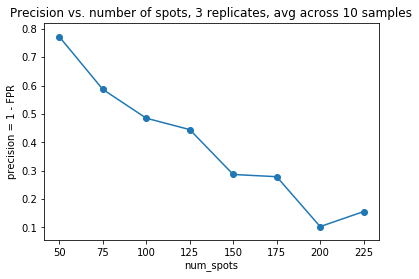

precision = [0.77, 0.59, 0.49, 0.44, 0.29, 0.28, 0.1, 0.16]

------------------------ num_replicates = 4 ------------------------


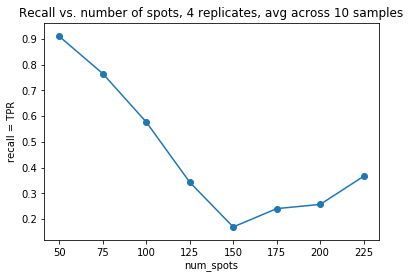

recall = [0.91, 0.77, 0.58, 0.34, 0.17, 0.24, 0.26, 0.37]


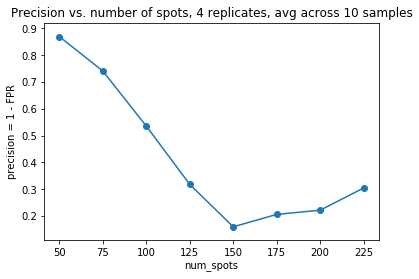

precision = [0.87, 0.74, 0.54, 0.32, 0.16, 0.21, 0.22, 0.3]

------------------------ num_replicates = 5 ------------------------


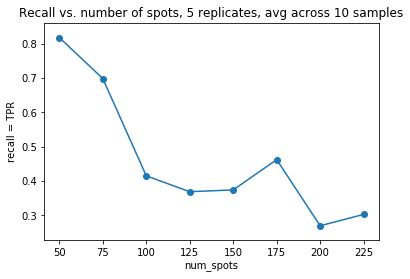

recall = [0.82, 0.7, 0.41, 0.37, 0.37, 0.46, 0.27, 0.3]


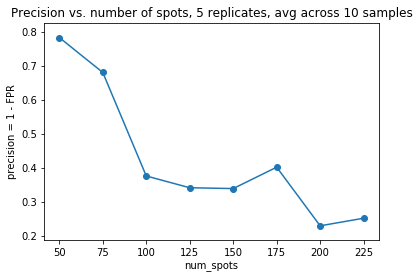

precision = [0.78, 0.68, 0.38, 0.34, 0.34, 0.4, 0.23, 0.25]

------------------------ num_replicates = 6 ------------------------


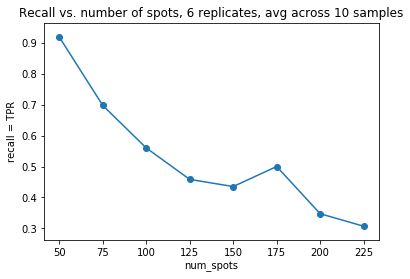

recall = [0.92, 0.7, 0.56, 0.46, 0.44, 0.5, 0.35, 0.31]


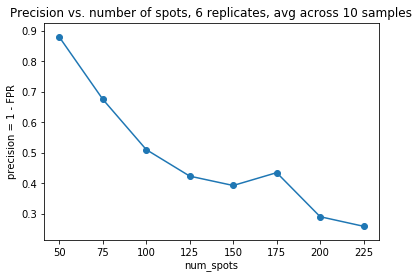

precision = [0.88, 0.68, 0.51, 0.42, 0.39, 0.44, 0.29, 0.26]

------------------------ num_replicates = 7 ------------------------


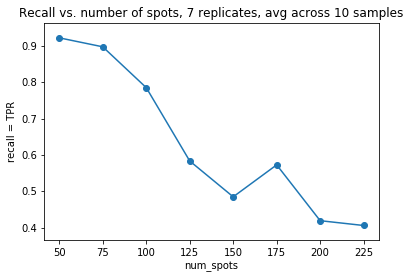

recall = [0.92, 0.9, 0.79, 0.58, 0.48, 0.57, 0.42, 0.41]


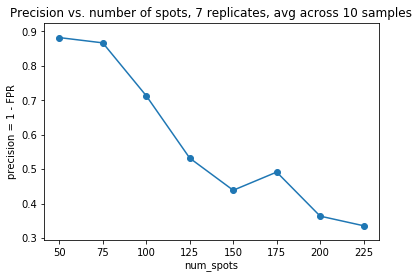

precision = [0.88, 0.87, 0.71, 0.53, 0.44, 0.49, 0.36, 0.34]

------------------------ num_replicates = 8 ------------------------


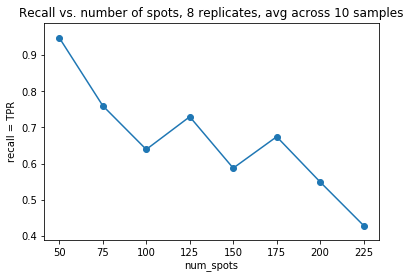

recall = [0.95, 0.76, 0.64, 0.73, 0.59, 0.67, 0.55, 0.43]


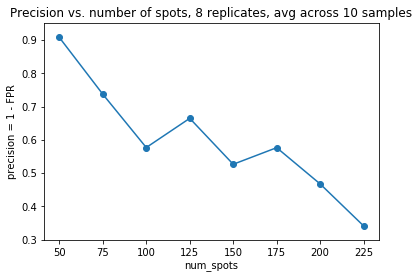

precision = [0.91, 0.74, 0.58, 0.66, 0.53, 0.58, 0.47, 0.34]

------------------------ num_replicates = 9 ------------------------


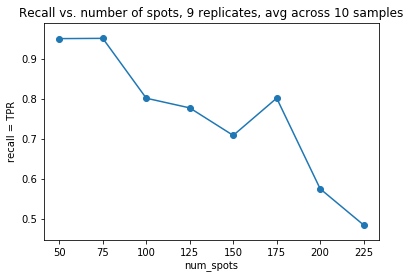

recall = [0.95, 0.95, 0.8, 0.78, 0.71, 0.8, 0.57, 0.48]


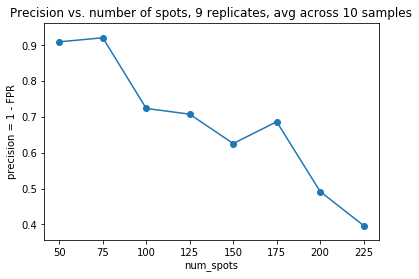

precision = [0.91, 0.92, 0.72, 0.71, 0.63, 0.69, 0.49, 0.4]

------------------------ num_replicates = 10 ------------------------


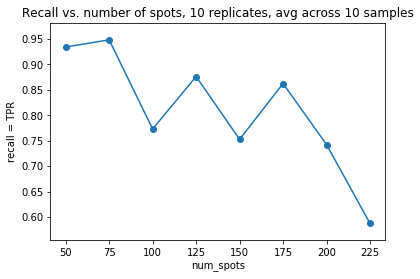

recall = [0.93, 0.95, 0.77, 0.88, 0.75, 0.86, 0.74, 0.59]


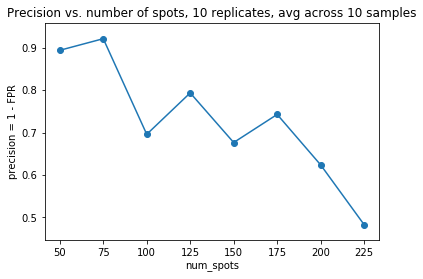

precision = [0.89, 0.92, 0.7, 0.79, 0.68, 0.74, 0.62, 0.48]

------------------------ num_replicates = 11 ------------------------


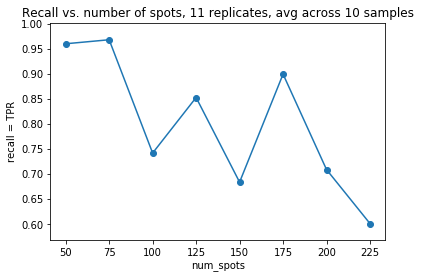

recall = [0.96, 0.97, 0.74, 0.85, 0.68, 0.9, 0.71, 0.6]


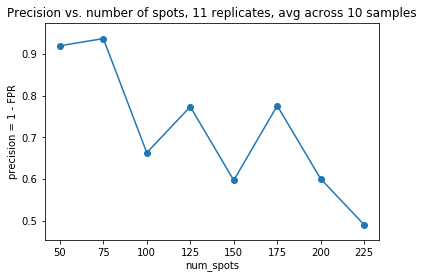

precision = [0.92, 0.94, 0.66, 0.77, 0.6, 0.78, 0.6, 0.49]

------------------------ num_replicates = 12 ------------------------


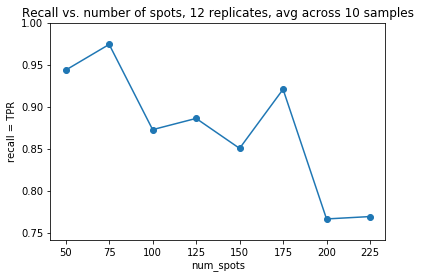

recall = [0.94, 0.97, 0.87, 0.89, 0.85, 0.92, 0.77, 0.77]


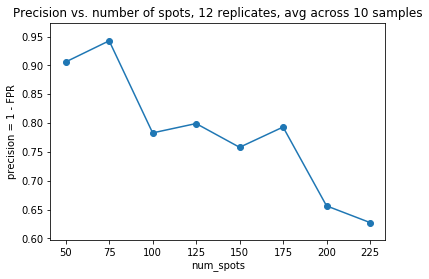

precision = [0.91, 0.94, 0.78, 0.8, 0.76, 0.79, 0.66, 0.63]

------------------------ num_replicates = 13 ------------------------


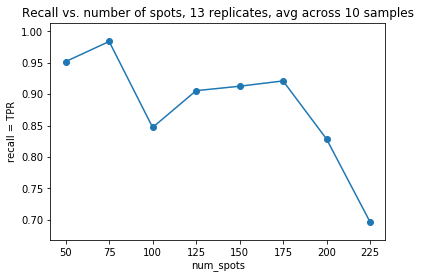

recall = [0.95, 0.98, 0.85, 0.91, 0.91, 0.92, 0.83, 0.7]


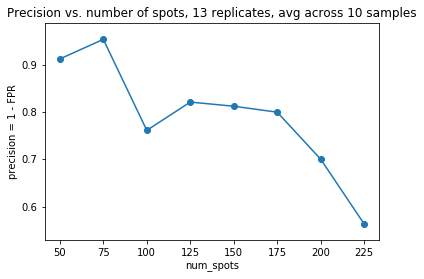

precision = [0.91, 0.95, 0.76, 0.82, 0.81, 0.8, 0.7, 0.56]

------------------------ num_replicates = 14 ------------------------


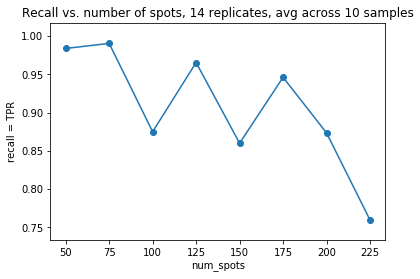

recall = [0.98, 0.99, 0.88, 0.97, 0.86, 0.95, 0.87, 0.76]


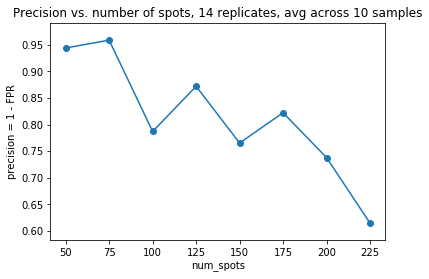

precision = [0.94, 0.96, 0.79, 0.87, 0.77, 0.82, 0.74, 0.61]

------------------------ num_replicates = 15 ------------------------


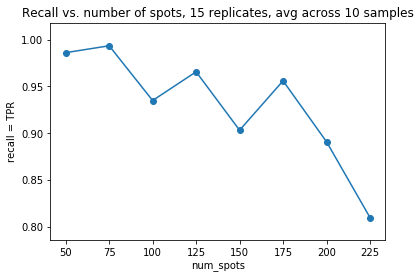

recall = [0.99, 0.99, 0.93, 0.97, 0.9, 0.96, 0.89, 0.81]


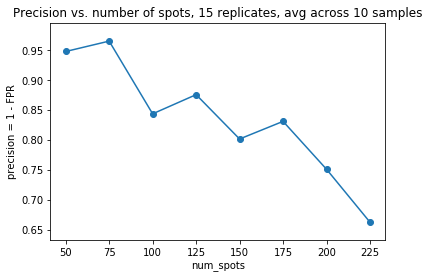

precision = [0.95, 0.97, 0.84, 0.88, 0.8, 0.83, 0.75, 0.66]

------------------------ num_replicates = 16 ------------------------


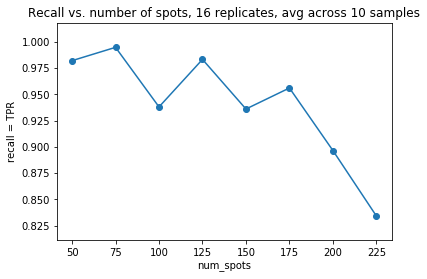

recall = [0.98, 0.99, 0.94, 0.98, 0.94, 0.96, 0.9, 0.83]


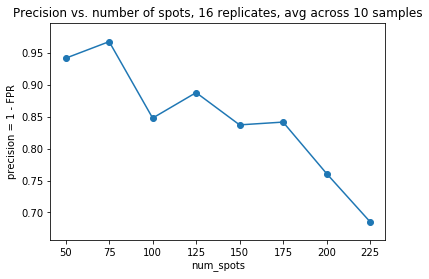

precision = [0.94, 0.97, 0.85, 0.89, 0.84, 0.84, 0.76, 0.69]

------------------------ num_replicates = 17 ------------------------


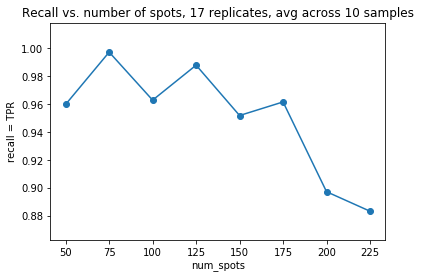

recall = [0.96, 1.0, 0.96, 0.99, 0.95, 0.96, 0.9, 0.88]


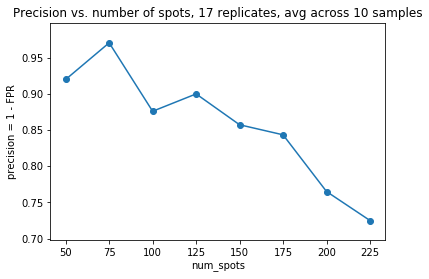

precision = [0.92, 0.97, 0.88, 0.9, 0.86, 0.84, 0.77, 0.72]

------------------------ num_replicates = 18 ------------------------


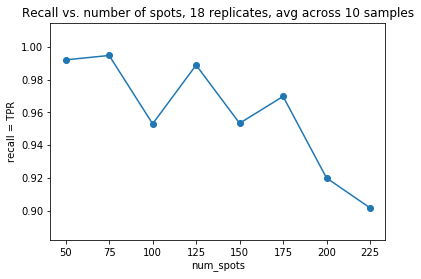

recall = [0.99, 0.99, 0.95, 0.99, 0.95, 0.97, 0.92, 0.9]


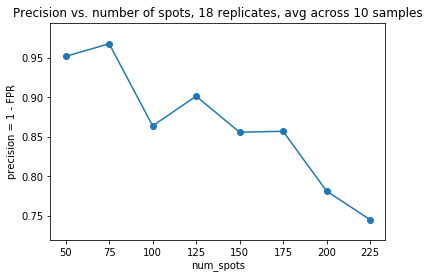

precision = [0.95, 0.97, 0.86, 0.9, 0.86, 0.86, 0.78, 0.75]

------------------------ num_replicates = 19 ------------------------


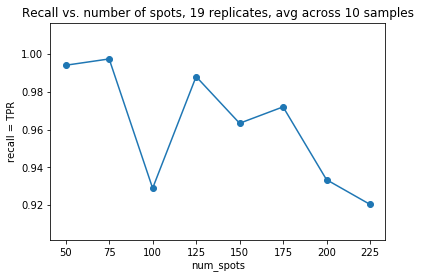

recall = [0.99, 1.0, 0.93, 0.99, 0.96, 0.97, 0.93, 0.92]


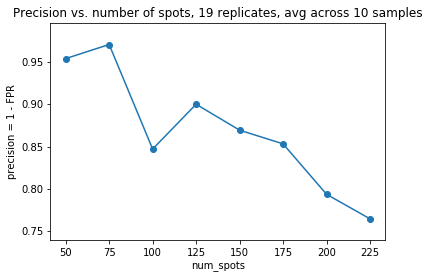

precision = [0.95, 0.97, 0.85, 0.9, 0.87, 0.85, 0.79, 0.76]

------------------------ num_replicates = 20 ------------------------


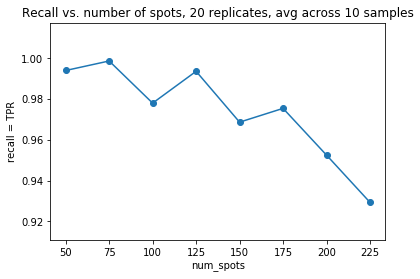

recall = [0.99, 1.0, 0.98, 0.99, 0.97, 0.98, 0.95, 0.93]


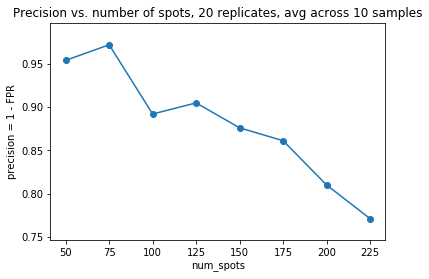

precision = [0.95, 0.97, 0.89, 0.9, 0.88, 0.86, 0.81, 0.77]

------------------------ num_replicates = 21 ------------------------


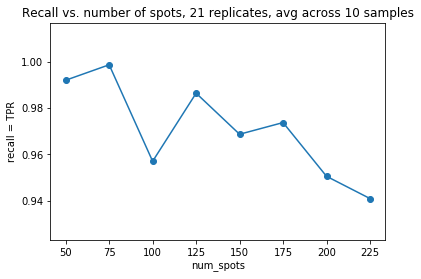

recall = [0.99, 1.0, 0.96, 0.99, 0.97, 0.97, 0.95, 0.94]


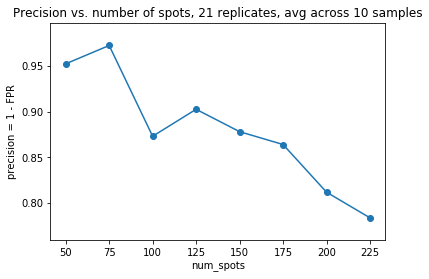

precision = [0.95, 0.97, 0.87, 0.9, 0.88, 0.86, 0.81, 0.78]

------------------------ num_replicates = 22 ------------------------


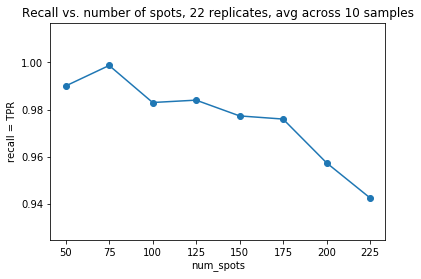

recall = [0.99, 1.0, 0.98, 0.98, 0.98, 0.98, 0.96, 0.94]


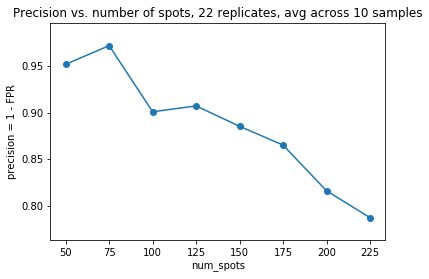

precision = [0.95, 0.97, 0.9, 0.91, 0.89, 0.87, 0.82, 0.79]

------------------------ num_replicates = 23 ------------------------


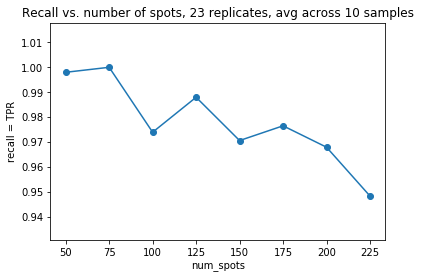

recall = [1.0, 1.0, 0.97, 0.99, 0.97, 0.98, 0.97, 0.95]


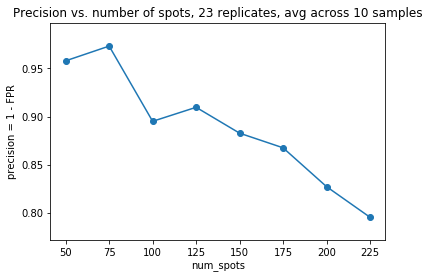

precision = [0.96, 0.97, 0.9, 0.91, 0.88, 0.87, 0.83, 0.8]

------------------------ num_replicates = 24 ------------------------


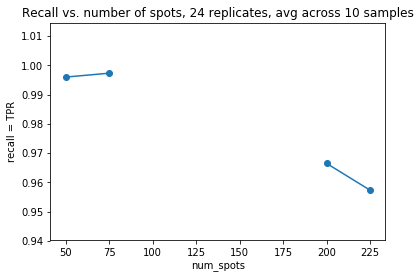

recall = [0.99600000000000011, 0.99733333333333329, None, None, None, None, 0.96650000000000014, 0.95733333333333337]


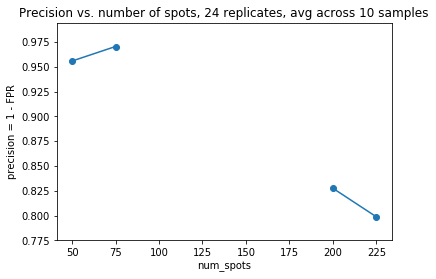

precision = [0.95599999999999996, 0.97066666666666668, None, None, None, None, 0.8274999999999999, 0.79866666666666664]

------------------------ num_replicates = 25 ------------------------
For all images in this set, the specified number of replicates is greater than the number of workers who annotated the image.


In [26]:
for recall, precision, n in zip(recall_list, precision_list, num_replicates_list):
                
    print('\n------------------------ num_replicates = ' + str(n) + ' ------------------------')

    if not any(recall):
        print('For all images in this set, the specified number of replicates is greater than the number of workers who annotated the image.')
        continue
    
    plt.scatter(num_spots_list, recall)
    plt.plot(num_spots_list, recall)
    plt.xlabel('num_spots')
    plt.ylabel('recall = TPR')
    plt.title('Recall vs. number of spots, ' + str(n) + ' replicates, avg across ' + str(num_iter) + ' samples')
    plt.show()
    if n < 24:
        print('recall = ' + str([round(x, 2) for x in recall]))
    else:
        print('recall = ' + str(recall))
    
    plt.scatter(num_spots_list, precision)
    plt.plot(num_spots_list, precision)
    plt.xlabel('num_spots')
    plt.ylabel('precision = 1 - FPR')
    plt.title('Precision vs. number of spots, ' + str(n) + ' replicates, avg across ' + str(num_iter) + ' samples')
    plt.show()
    if n < 24:
        print('precision = ' + str([round(x, 2) for x in precision]))
    else:
        print('precision = ' + str(precision))
    

In [14]:
# np.savetxt('TPR_list_list.csv', np.asarray(TPR_list_list), delimiter=',', comments='')
# np.savetxt('FPR_list_list.csv', np.asarray(FPR_list_list), delimiter=',', comments='')
# np.savetxt('recall_list.csv', np.asarray(recall_list), delimiter=',', comments='', fmt='%s')
# np.savetxt('precision_list.csv', np.asarray(precision_list), delimiter=',', comments='', fmt='%s')
# np.savetxt('num_replicates_list.csv', np.asarray(num_replicates_list), delimiter=',', comments='')
# np.savetxt('num_spots_list.csv', np.asarray(num_spots_list), delimiter=',', comments='')

# print('TPR_list_list')
# print(TPR_list_list)
# print('\n\n\n')
# print('FPR_list_list')
# print(FPR_list_list)
# print('recall_list')
# print(recall_list)
# print('precision_list')
# print(precision_list)
# print('num_replicates_list')
# print(num_replicates_list)
# print('num_spots_list')
# print(num_spots_list)